Exercise on using Custom Components in Tensorflow, like custom Loss functions, Layers, Models

In [2]:
# import Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, ReLU, Add, Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Softmax, AveragePooling2D

import matplotlib.pyplot as plt
import os

In [33]:
# temporary import



In [7]:
# specify variables for full-paths
base_dir = 'apple-or-tomato/'

train_dir = base_dir + 'training_set/'
validation_dir = base_dir + 'test_set/'

train_apple_dir = train_dir + 'apple/'
train_tomato_dir = train_dir + 'tomato/'
validation_apple_dir = validation_dir + 'apple/'
validation_tomato_dir = validation_dir + 'tomato/'

# get no of images in training & validation sets
total_train = len(os.listdir(train_apple_dir)) + len(os.listdir(train_tomato_dir))
total_val = len(os.listdir(validation_apple_dir)) + len(os.listdir(validation_tomato_dir))

In [9]:
# create the Data-gen pipeline
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

batch_size, img_height, img_width  = 32, 224, 224

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size, directory=train_dir, shuffle=True, 
        target_size=(img_height, img_width), class_mode='binary'
)
validation_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size, directory=validation_dir, target_size=(img_height, img_width),
    class_mode='binary'
)

Found 1300 images belonging to 2 classes.
Found 648 images belonging to 2 classes.


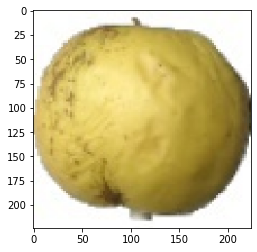

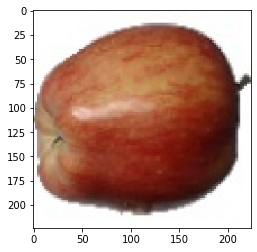

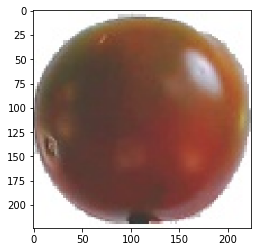

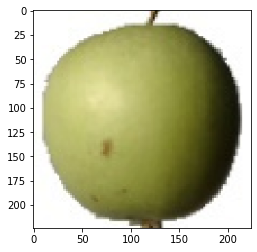

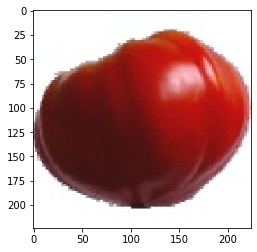

In [10]:
# display some images
for _ in range(5):
    img, label = train_data_gen.next()
    plt.imshow(img[0])
    plt.show()

Implementing custom loss function

In [13]:
# create Custom loss function
def custom_loss_function(y_true, y_pred):
    print("Calculating custom loss function")
    squared_difference = tf.square(float(y_true) - float(y_pred))
    return tf.reduce_mean(squared_difference, axis=-1)

In [20]:
# download the NASNetMobile weights
# NASNetMobile input shape is (224, 244, 3), not (100, 100, 3)
base_model = NASNetMobile(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

20004864/19993432 [==============================] - 91s 5us/step


In [23]:
# create the MODEL
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(500, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               25872500  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 30,142,717
Trainable params: 25,873,001
Non-trainable params: 4,269,716
_________________________________________________________________


In [25]:
model.compile(
    optimizer='adam', loss=custom_loss_function, metrics=['accuracy']
)
history = model.fit(
    train_data_gen, steps_per_epoch=total_train // batch_size, epochs=5,
    validation_data=validation_data_gen, validation_steps=total_val // batch_size
)


Epoch 1/5
Calculating custom loss function
Calculating custom loss function
40/40 [==============================] - 118s 3s/step - loss: 0.1372 - accuracy: 0.8580 - val_loss: 0.0241 - val_accuracy: 0.9750
Epoch 2/5
40/40 [==============================] - 95s 2s/step - loss: 0.0253 - accuracy: 0.9748 - val_loss: 0.0204 - val_accuracy: 0.9797
Epoch 3/5
40/40 [==============================] - 96s 2s/step - loss: 0.0359 - accuracy: 0.9637 - val_loss: 0.0359 - val_accuracy: 0.9641
Epoch 4/5
40/40 [==============================] - 103s 3s/step - loss: 0.0379 - accuracy: 0.9621 - val_loss: 0.0480 - val_accuracy: 0.9516
Epoch 5/5
40/40 [==============================] - 100s 3s/step - loss: 0.0402 - accuracy: 0.9590 - val_loss: 0.0872 - val_accuracy: 0.9125


Custom layers

In [ ]:
# custom layer with ReLu activation & BatchNormalization
def relu_batchnorm_layer(input):
    return BatchNormalization()(ReLU()(input))

# custom layer with Simple Residual block
def simple_residual_block(input, filters: int, kernel_size: int = 3):
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(input)
    int_output = Conv2D(filters=filters, kernel_size=1, strides=2, padding='same')(int_output)
    output = Add()([int_output, input]) # skip connection
    output = relu_batchnorm_layer(output)
    return output



# using the Custom components with Functional API
inputs = Input(shape=(224, 224, 3))
num_filters = 32

t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3, strides=1, filters=32, padding='same')(t)
t = relu_batchnorm_layer(t)
t = simple_residual_block(t, filters=num_filters)
t = AveragePooling2D(4)(t)
t = Flatten(t)
outputs = Dense(1, activation='sigmoid')(t)

model = Model(inputs, outputs)

Building custom layers with SubClassing

In [35]:
# custom Model
class MyModel(Model):
    # initialize the Dense layers
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)

    # call the Initialized layers
    def call(self, inputs, training=True):
        X = self.dense_1(inputs)
        if training:
            X = self.dropout(X)
        return self.dense_2(X)


# implementing the Custom model
model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  704       
_________________________________________________________________
dense_5 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________
